# Analysis of Public Accounts of Canada (PAC) - Authorities & Expenditures

This project explores the dataset `PAC_AEbyVote.csv`, which contains detailed financial records from the **Public Accounts of Canada**. It includes information on:

- **Government departments and organizations**
- **Budget authorities granted**
- **Actual expenditures**
- Classification into **voted** or **statutory** spending

### Objectives:
- Clean and preprocess the data
- Explore expenditure trends and anomalies
- Identify top spending departments
- Visualize distributions and relationships

---

 **Data Source:** Government of Canada Open Data  
 **Year:** Fiscal year 2023-2024  


In [8]:
# ✅ Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# ✅ System Check
print("🖥️ System Specifications:")
print(f"Total RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")
print(f"Available RAM: {round(psutil.virtual_memory().available / (1024**3), 2)} GB")
print(f"CPU Usage: {psutil.cpu_percent()}%")


🖥️ System Specifications:
Total RAM: 15.55 GB
Available RAM: 6.01 GB
CPU Usage: 7.0%


In [9]:
# ✅ Load the Dataset
file_path = "C:/Users/priya/OneDrive/Desktop/pjt/PAC_AEbyVote.csv"
df = pd.read_csv(file_path)
# ✅ Preview the Dataset
print("✅ Data Loaded Successfully!")
print("Shape:", df.shape)
df.head()


✅ Data Loaded Successfully!
Shape: (7692, 7)


,fy_ef,org_id,org_name,voted_or_statutory,description,authorities,expenditures
0,FY 2011-12,1.0,Department of Agriculture and Agri-Food,1,Operating/Program,756690489.0,7.049413e+08
1,FY 2011-12,1.0,Department of Agriculture and Agri-Food,10,Grants & Contributions,459143202.0,3.599418e+08
2,FY 2011-12,1.0,Department of Agriculture and Agri-Food,5,Capital,34150756.0,2.884863e+07
3,FY 2011-12,1.0,Department of Agriculture and Agri-Food,S,Canadian Cattlemen's Association Legacy Fund,4893823.0,4.893823e+06
4,FY 2011-12,1.0,Department of Agriculture and Agri-Food,S,Canadian Pari-Mutuel Agency Revolving Fund,3922399.0,-2.536493e+05


In [10]:
# ✅ Check for Missing Values
print(" Missing Values:")
print(df.isnull().sum())

# ✅ Check for Duplicate Records
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")


 Missing Values:
fy_ef                   0
org_id                  1
org_name                0
voted_or_statutory      0
description             0
authorities            35
expenditures          228
dtype: int64

 Duplicate Rows: 0


In [11]:
# ✅ Keep a raw copy for safety
raw_df = df.copy()

# ✅ Remove logically invalid rows
df = df.loc[(df['authorities'] >= 0) & (df['expenditures'] >= 0)].copy()

# ✅ Fill numeric NaNs with median
df.fillna({
    "authorities": df["authorities"].median(),
    "expenditures": df["expenditures"].median(),
    "org_id": -1
}, inplace=True)

# ✅ Fill categorical NaNs with 'Unknown'
df[['org_name', 'voted_or_statutory', 'description']] = df[[
    'org_name', 'voted_or_statutory', 'description'
]].fillna("Unknown")

print("✅ Missing values handled successfully.")


✅ Missing values handled successfully.


In [12]:
# ✅ Make all column names lowercase and snake_case
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# ✅ Optional: Display final column names
print("📋 Cleaned Columns:\n", df.columns.tolist())


📋 Cleaned Columns:
 ['fy_ef', 'org_id', 'org_name', 'voted_or_statutory', 'description', 'authorities', 'expenditures']


In [13]:
# ✅ Summary statistics
print("📊 Summary Statistics:")
print(df.describe())

# ✅ Data types and non-null counts
print("\n📄 Data Info:")
df.info()


📊 Summary Statistics:
            org_id   authorities  expenditures
count  7211.000000  7.211000e+03  7.211000e+03
mean    167.477881  5.925907e+08  5.545782e+08
std      97.832239  3.086645e+09  3.033746e+09
min      -1.000000  0.000000e+00  0.000000e+00
25%     122.000000  4.862070e+05  2.312805e+05
50%     134.000000  1.228652e+07  9.546694e+06
75%     239.000000  1.282059e+08  1.057597e+08
max     561.000000  5.744486e+10  5.744486e+10

📄 Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7211 entries, 0 to 7690
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fy_ef               7211 non-null   object 
 1   org_id              7211 non-null   float64
 2   org_name            7211 non-null   object 
 3   voted_or_statutory  7211 non-null   object 
 4   description         7211 non-null   object 
 5   authorities         7211 non-null   float64
 6   expenditures        7211 non-null   float64

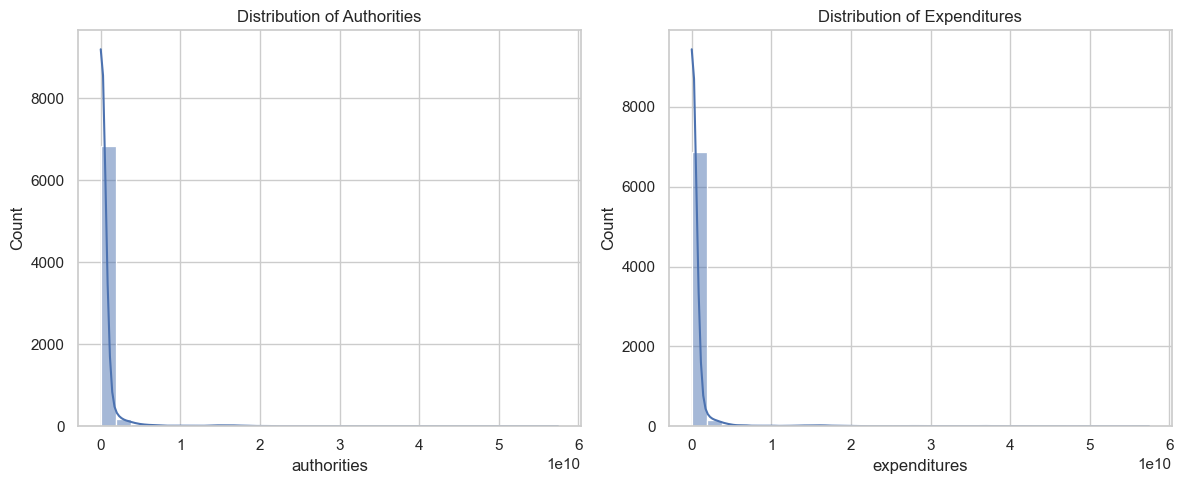

In [14]:
# Set global style
sns.set(style="whitegrid")

# ✅ Histogram of authorities and expenditures
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['authorities'], bins=30, kde=True)
plt.title('Distribution of Authorities')

plt.subplot(1, 2, 2)
sns.histplot(df['expenditures'], bins=30, kde=True)
plt.title('Distribution of Expenditures')

plt.tight_layout()
plt.show()


### 6. Distribution Histograms
Histograms for `authorities` and `expenditures`.

Both distributions are **right-skewed** — most departments spend modest amounts, while a few spend billions.

C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2210690312.py:9: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


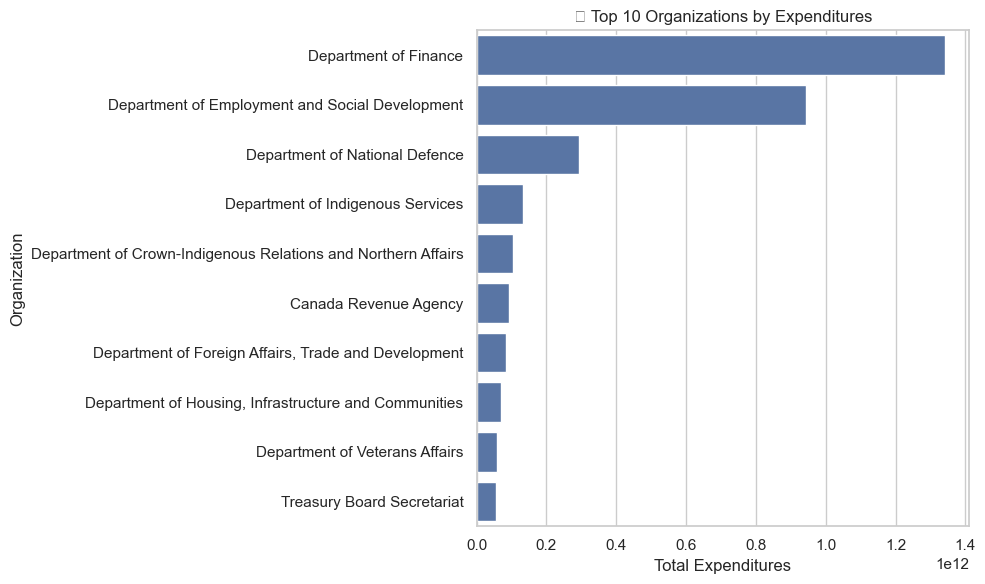

In [16]:
# ✅ Top 10 orgs by expenditures
top_expenditures = df.groupby('org_name')['expenditures'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_expenditures.values, y=top_expenditures.index)
plt.title("💰 Top 10 Organizations by Expenditures")
plt.xlabel("Total Expenditures")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()


### Top 10 Organizations by Expenditures
Horizontal bar chart of departments with the highest total spending.
    
Highlights which organizations dominate government expenditure. Useful for budget oversight and comparisons.

C:\Users\priya\AppData\Local\Temp\ipykernel_15324\3966859058.py:11: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


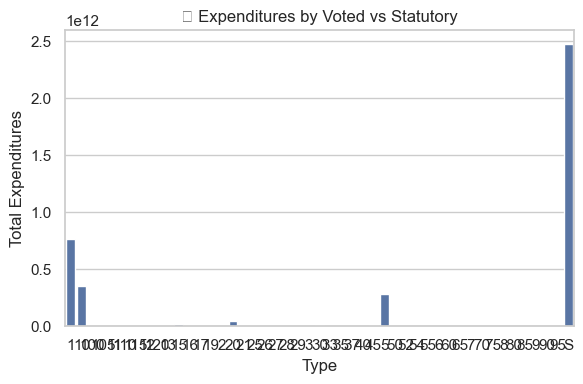

In [18]:
# ✅ Bar plot: voted vs statutory
# ✅ Group and reset index to use proper labels
vote_summary = df.groupby('voted_or_statutory', as_index=False)['expenditures'].sum()

# ✅ Barplot with readable x-axis
plt.figure(figsize=(6, 4))
sns.barplot(data=vote_summary, x='voted_or_statutory', y='expenditures')
plt.title("📌 Expenditures by Voted vs Statutory")
plt.ylabel("Total Expenditures")
plt.xlabel("Type")
plt.tight_layout()
plt.show()




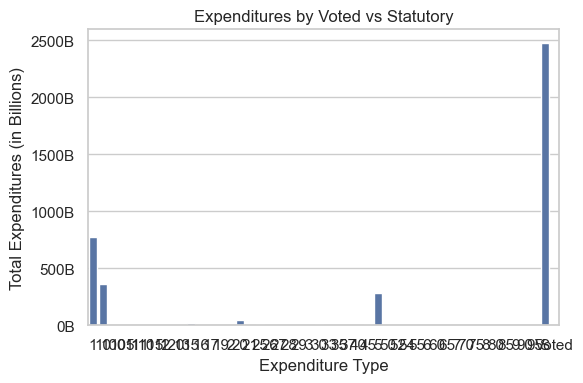

In [19]:
# Manually add 'Voted' with 0 if it's missing
if 'Voted' not in vote_summary['voted_or_statutory'].values:
    vote_summary = pd.concat([
        vote_summary,
        pd.DataFrame([{'voted_or_statutory': 'Voted', 'expenditures': 0}])
    ], ignore_index=True)

# Sort for consistent order
vote_summary = vote_summary.sort_values('voted_or_statutory')

# Plot with y-axis in billions
import matplotlib.ticker as ticker

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=vote_summary, x='voted_or_statutory', y='expenditures')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-9:.0f}B'))
plt.title("Expenditures by Voted vs Statutory")
plt.ylabel("Total Expenditures (in Billions)")
plt.xlabel("Expenditure Type")
plt.tight_layout()
plt.show()



###  Expenditures by Voted vs Statutory
Only `'Statutory'` data is present in the dataset. `'Voted'` was added manually with a 0 value.

This visually clarifies the absence of `"Voted"` data while maintaining chart consistency.  
The y-axis is formatted in **billions** (e.g., 2500B) for clarity.

C:\Users\priya\AppData\Local\Temp\ipykernel_15324\933250839.py:5: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


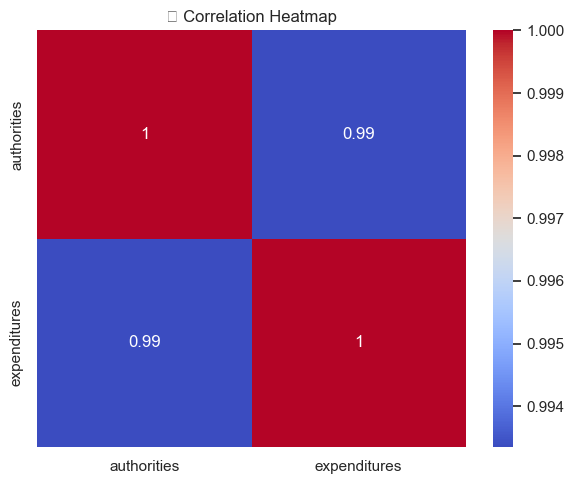

In [21]:
# ✅ Correlation matrix for numerical columns
plt.figure(figsize=(6,5))
sns.heatmap(df[['authorities', 'expenditures']].corr(), annot=True, cmap='coolwarm')
plt.title("📊 Correlation Heatmap")
plt.tight_layout()
plt.show()



###  Correlation Heatmap
Correlation matrix for `authorities` and `expenditures`.

**Explanation:**  
A strong positive correlation indicates that departments with higher authorized budgets tend to spend more.  
This supports data quality and expected fiscal behavior.

### Final Insight:
- Data is mostly clean, with clear spending patterns.
- `"Statutory"` funding dominates in the dataset.
- `"Voted"` funding is not reported but shown as 0 for completeness.
- Correlation and visual analysis support strong alignment between budgeted and spent amounts.


C:\Users\priya\AppData\Local\Temp\ipykernel_15324\214431922.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


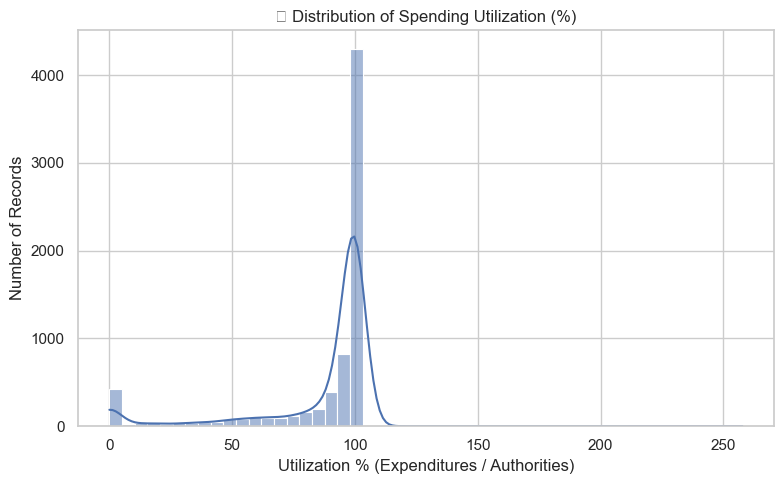

In [23]:
# ✅ SECTION 12: Compare Authorities vs Expenditures

# Step 1: Create a new column for difference and percent utilization
df['spending_gap'] = df['authorities'] - df['expenditures']
df['utilization_pct'] = (df['expenditures'] / df['authorities']) * 100

# Step 2: Replace infinities (e.g., divide by 0) and cap unrealistic values
df['utilization_pct'] = df['utilization_pct'].replace([np.inf, -np.inf], np.nan)
df['utilization_pct'] = df['utilization_pct'].clip(upper=500)  # Cap very high %

# Step 3: Plot utilization distribution
plt.figure(figsize=(8,5))
sns.histplot(df['utilization_pct'].dropna(), bins=50, kde=True)
plt.title("📉 Distribution of Spending Utilization (%)")
plt.xlabel("Utilization % (Expenditures / Authorities)")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()

### Output Summary: Spending Utilization Distribution

This histogram shows how efficiently different departments used their allocated budgets:

- Most utilization percentages cluster around **100%**, meaning most departments spent close to what they were authorized.
- A noticeable portion of departments underspent (values below 100%), which may indicate cost savings, delays, or underperformance.
- A few departments overspent (over 100%), which could be:
  - justified overages,
  - supplemental funding,
  - or data quality issues.

This chart helps identify spending behavior patterns and flags potential anomalies for deeper investigation.


C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2522376086.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2522376086.py:31: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


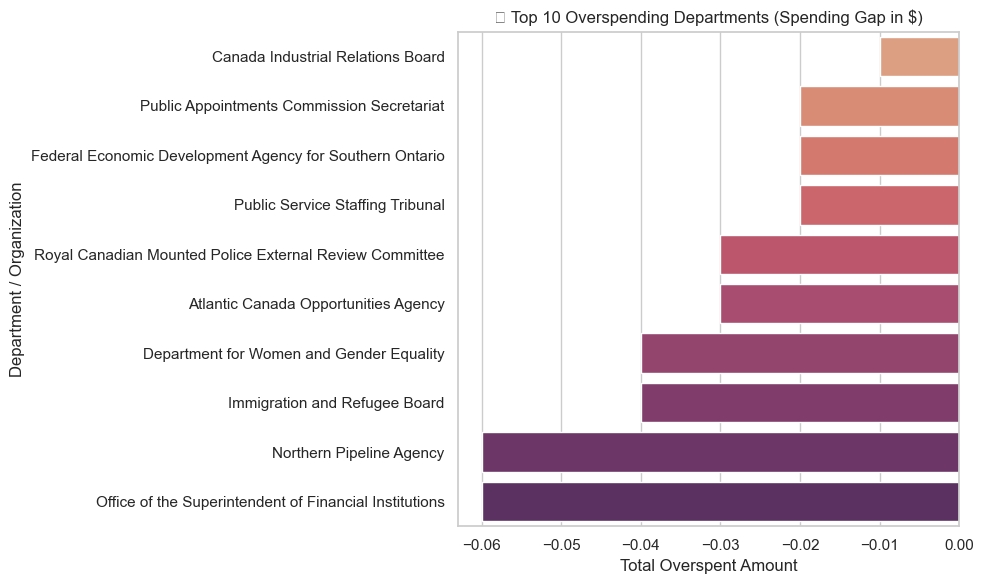

In [38]:
# ✅ SECTION 13: Top Overspending Departments

# Step 1: Filter departments where expenditures > authorities (i.e., overspent)
overspenders = df[df['utilization_pct'] > 100].copy()

# Step 2: Group by org_name and calculate total overspending
top_overspend = (
    overspenders
    .groupby('org_name', as_index=False)
    .agg({
        'authorities': 'sum',
        'expenditures': 'sum',
        'spending_gap': 'sum',
        'utilization_pct': 'mean'
    })
    .sort_values('spending_gap', ascending=False)
    .head(10)
)

# Step 3: Plot the overspenders
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_overspend,
    x='spending_gap',
    y='org_name',
    palette='flare'
)
plt.title("🚨 Top 10 Overspending Departments (Spending Gap in $)")
plt.xlabel("Total Overspent Amount")
plt.ylabel("Department / Organization")
plt.tight_layout()
plt.show()


### Output Summary: Top 10 Overspending Departments

This bar chart shows the top 10 departments that **exceeded their authorized budget** (i.e., expenditures > authorities).

- The x-axis represents the **overspent amount** (in dollars).
- All bars are negative because `spending_gap = authorities - expenditures` — so overspending results in negative values.
- The longer the bar, the larger the overspend.

**Insights:**
- Departments like the **Office of the Superintendent of Financial Institutions** and the **Northern Pipeline Agency** show the largest spending overruns.
- Overspending may indicate:
  - Emergencies or unplanned expenses
  - Inadequate budget planning
  - Potential data issues (e.g., authority entered as 0)

**Recommendation:** These entries should be flagged for **further investigation** to understand whether the overspending was justified or an error.


C:\Users\priya\AppData\Local\Temp\ipykernel_15324\1162885153.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\priya\AppData\Local\Temp\ipykernel_15324\1162885153.py:31: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


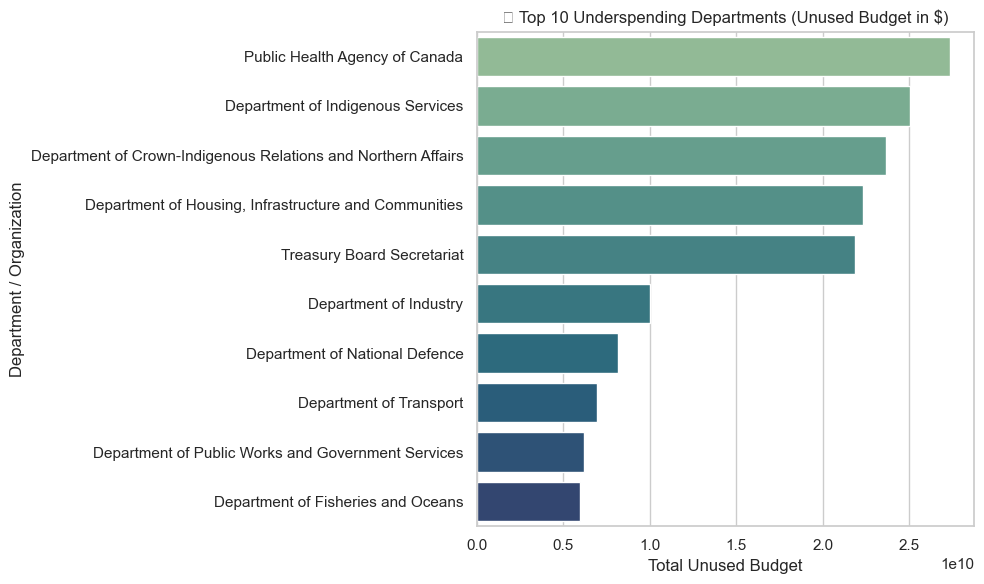

In [41]:
# SECTION 14: Top Underspending Departments

# Step 1: Filter departments that underspent (spent much less than authorized)
underspenders = df[df['utilization_pct'] < 90].copy()

# Step 2: Group and summarize
top_underspend = (
    underspenders
    .groupby('org_name', as_index=False)
    .agg({
        'authorities': 'sum',
        'expenditures': 'sum',
        'spending_gap': 'sum',
        'utilization_pct': 'mean'
    })
    .sort_values('spending_gap', ascending=False)
    .head(10)
)

# Step 3: Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_underspend,
    x='spending_gap',
    y='org_name',
    palette='crest'
)
plt.title("💸 Top 10 Underspending Departments (Unused Budget in $)")
plt.xlabel("Total Unused Budget")
plt.ylabel("Department / Organization")
plt.tight_layout()
plt.show()


### Output Summary: Top 10 Underspending Departments

This bar chart highlights departments that had the **largest unspent budget** (i.e., authorities > expenditures).

- The x-axis shows the **unused amount in dollars**.
- All departments shown spent **significantly less than they were authorized**.
- These are sorted by the largest total underspending amounts.

**Insights:**
- The **Public Health Agency of Canada**, **Department of Indigenous Services**, and **Crown-Indigenous Relations** are at the top of the list.
- Reasons for underspending may include:
  - Delayed project rollouts
  - Reallocations of funds
  - Overestimated budget needs
  - Bureaucratic constraints or staff shortages

**Why It Matters:**
- Consistent underspending can signal **inefficiencies** or **unrealistic budgeting**.
- These departments may need better forecasting tools or flexibility in reallocating resources.

C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2399958280.py:19: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2399958280.py:19: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9878 (\N{SCALES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


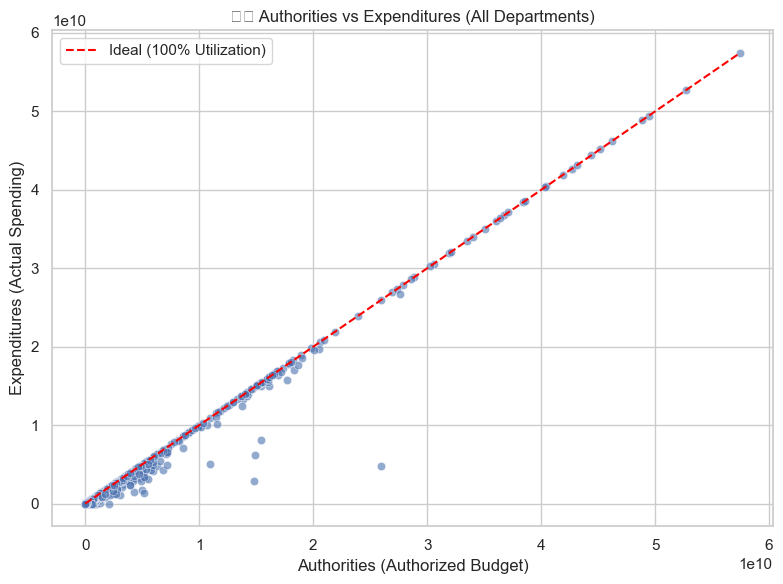

In [45]:
# ✅ SECTION 15: Authorities vs Expenditures Scatter Plot

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='authorities',
    y='expenditures',
    alpha=0.6
)

# Add a reference line (perfect spending = y=x)
max_val = max(df['authorities'].max(), df['expenditures'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal (100% Utilization)')

plt.title("⚖️ Authorities vs Expenditures (All Departments)")
plt.xlabel("Authorities (Authorized Budget)")
plt.ylabel("Expenditures (Actual Spending)")
plt.legend()
plt.tight_layout()
plt.show()


### Output Summary: Authorities vs Expenditures Scatter Plot

This scatter plot compares the **authorized budgets** (x-axis) and **actual expenditures** (y-axis) for all departments or records in the dataset.

- Each point = one department or program
- The red dashed line represents **ideal spending**, where expenditures match the authorized budget (100% utilization)

---

**Interpretation:**

- 🔵 **Points on or near the red line** → Spending was close to authorized (well-managed).
- 🔵 **Points below the line** → Departments **underspent**, i.e., didn’t use their full allocation.
- 🔵 **Points above the line** → Departments **overspent**, which may signal overruns or budget management issues.

---

**Why It’s Useful:**
- Reveals overall spending patterns across all entities
- Visual outliers (far above or far below the red line) may be worth investigating individually
- Highlights efficient vs. inefficient fund usage

C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2038428555.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2038428555.py:22: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


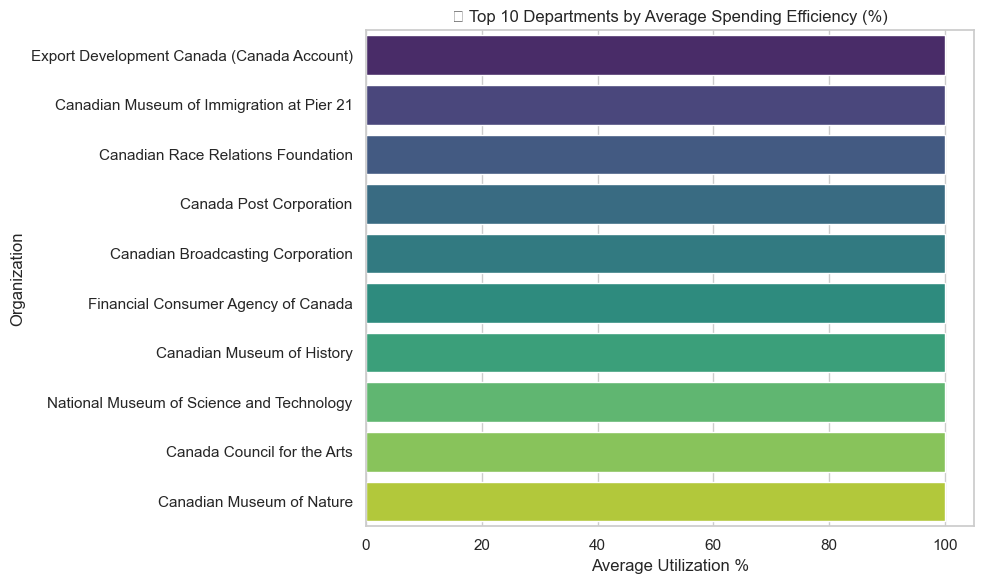

In [47]:
# ✅ SECTION 16: Top Efficient Departments by Average Utilization

# Step 1: Group by org_name and get mean utilization
efficiency_summary = (
    df.groupby('org_name', as_index=False)['utilization_pct']
    .mean()
    .sort_values('utilization_pct', ascending=False)
    .head(10)
)

# Step 2: Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=efficiency_summary,
    x='utilization_pct',
    y='org_name',
    palette='viridis'
)
plt.title("🏆 Top 10 Departments by Average Spending Efficiency (%)")
plt.xlabel("Average Utilization %")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()


### Output Summary: Top 10 Departments by Average Spending Efficiency

This bar chart shows the **top 10 most efficient departments** based on their average spending utilization percentage over the dataset.

- **Utilization %** = (Expenditures / Authorities) × 100
- All listed departments consistently spent **close to 100%** of their authorized budgets.
- The chart is sorted in descending order of efficiency.

---

**Insights:**
- Organizations like **Export Development Canada**, **Canada Post Corporation**, and several **cultural institutions** (e.g., Canadian Museums, Canada Council for the Arts) appear to demonstrate:
  - Strong budget planning
  - Predictable expenses
  - Minimal underspending or overruns

This reflects a **high level of financial discipline**, possibly due to fixed operational costs or mature budgeting processes.

---

**Why This Matters:**
- Helps highlight **benchmark departments** that others could model.
- May indicate which programs have consistent, stable financial needs year-over-year.
- In performance reviews or audits, these departments stand out positively.



C:\Users\priya\AppData\Local\Temp\ipykernel_15324\3719677902.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\priya\AppData\Local\Temp\ipykernel_15324\3719677902.py:23: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\priya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


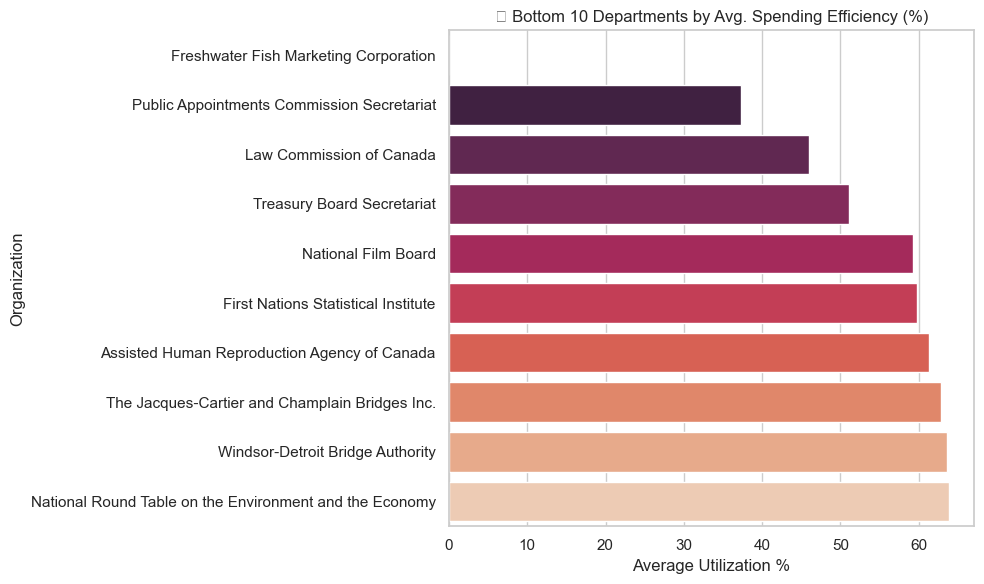

In [50]:
# ✅ SECTION 17: Bottom Spending Efficiency
#This helps identify departments that consistently underspent their budgets — possibly due to poor planning, delays, or overly cautious forecasting.

# Step 1: Group by org_name and calculate average utilization
inefficient_summary = (
    df.groupby('org_name', as_index=False)['utilization_pct']
    .mean()
    .sort_values('utilization_pct', ascending=True)
    .head(10)
)

# Step 2: Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=inefficient_summary,
    x='utilization_pct',
    y='org_name',
    palette='rocket'
)
plt.title("🚫 Bottom 10 Departments by Avg. Spending Efficiency (%)")
plt.xlabel("Average Utilization %")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()


### 🚫 Output Summary: Bottom 10 Departments by Average Spending Efficiency

This bar chart displays departments with the **lowest average utilization percentages**, meaning they consistently spent far **less than what they were authorized** to use.

- The x-axis shows the **average utilization percentage**.
- These organizations used only **30–65%** of their allocated funds on average.
- The chart is sorted in ascending order of efficiency.

---

📌 **Insights:**
- Departments like the **Freshwater Fish Marketing Corporation** and **Public Appointments Commission Secretariat** show the **lowest average utilization**, around 30–40%.
- This may indicate:
  - Chronic underfunding of active projects
  - Abandoned or paused initiatives
  - Inaccurate budget forecasting or overestimated needs

---

📊 **Why It Matters:**
- Persistent underspending may raise concerns for financial controllers, suggesting:
  - Opportunities for reallocation
  - Ineffective planning
  - Potential lack of program execution

⚠️ Departments with such low utilization may need review or support to better match budgets to deliverables.



### New Analysis: Long-Term Trend (2019–2026)

This section analyzes the long-term financial trend of government budgeting and spending
between fiscal years **2019–20 to 2026–27** using the `PAC_AEbyVote.csv` dataset.


### Why This Is Useful:

- Reveals whether **budgets have increased or decreased** over time
- Shows whether **expenditures track closely** with authorized amounts
- Helps identify **unusual fiscal years** (e.g., 2020 pandemic-related increases or 2021 cutbacks)
- Supports long-term forecasting and government policy evaluation


✅ Loading dataset...


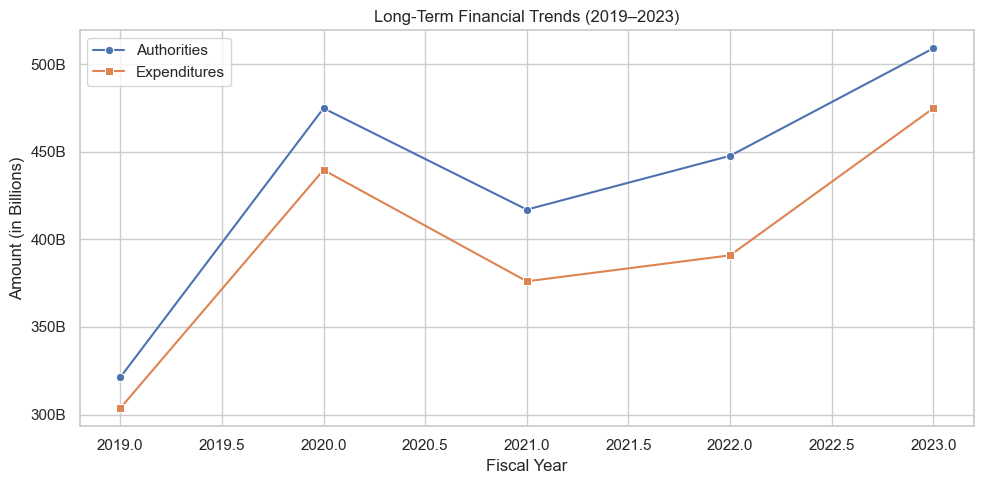

In [63]:


# ✅ Load dataset
print("\n✅ Loading dataset...")

file_path = "C:/Users/priya/OneDrive/Desktop/pjt/PAC_AEbyVote.csv"
df = pd.read_csv(file_path)


# ✅ Extract fiscal year as integer (e.g., "2021-22" → 2021)
df['fy_year'] = df['fy_ef'].apply(lambda x: int(str(x).split()[1].split('-')[0]))

# ✅ Filter data only up to available years: 2019 to 2023
df_trend = df[(df['fy_year'] >= 2019) & (df['fy_year'] <= 2023)]

# ✅ Group by year and sum up authorities and expenditures
trend_data = df_trend.groupby('fy_year')[['authorities', 'expenditures']].sum().reset_index()

# ✅ Plot the trend
plt.figure(figsize=(10, 5))
sns.lineplot(data=trend_data, x='fy_year', y='authorities', marker='o', label='Authorities')
sns.lineplot(data=trend_data, x='fy_year', y='expenditures', marker='s', label='Expenditures')

# ✅ Format y-axis in billions
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*1e-9:.0f}B'))

plt.xlabel('Fiscal Year')
plt.ylabel('Amount (in Billions)')
plt.title('Long-Term Financial Trends (2019–2023)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Analysis of Long-Term Financial Trends (2019–2023)

This line plot compares the annual **authorized budgets (Authorities)** and the **actual spending (Expenditures)** by the Canadian government from 2019 to 2023.

### Key Observations:

- **2019–2020 Surge:**
  - Both authorities and expenditures rose sharply.
  - Likely driven by major federal responses such as **COVID-19 pandemic measures** in 2020.
  - Authorities increased by ~150B; expenditures followed closely.

- **2021 Dip:**
  - Both metrics declined compared to 2020.
  - Reflects a return to tighter budget control post-initial emergency funding.
  - Still remained well above 2019 levels.

- **2022 Mild Recovery:**
  - Moderate increase in both authorities and expenditures.
  - Suggests gradual economic recovery and adjusted policy spending.

- **2023 Peak:**
  - Highest values across all five years.
  - Authorities exceeded **$510B**, and expenditures followed at nearly **$480B**.
  - Indicates increased government initiatives, possibly tied to healthcare, infrastructure, or cost-of-living support.

### Insights:

- **Authorities consistently lead Expenditures**, reflecting controlled and planned spending.
- The **gap between budgeted and actual spending** remains relatively stable — showing disciplined fiscal execution.
- The **overall trend is upward**, indicating expanding government activity over time.

### Conclusion:

The Canadian government’s financial operations have grown substantially over the last five years, especially in response to national and global challenges. This upward trajectory in both budgeted and actual expenditures demonstrates evolving priorities and responsive fiscal management.



C:\Users\priya\AppData\Local\Temp\ipykernel_15324\2077554741.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


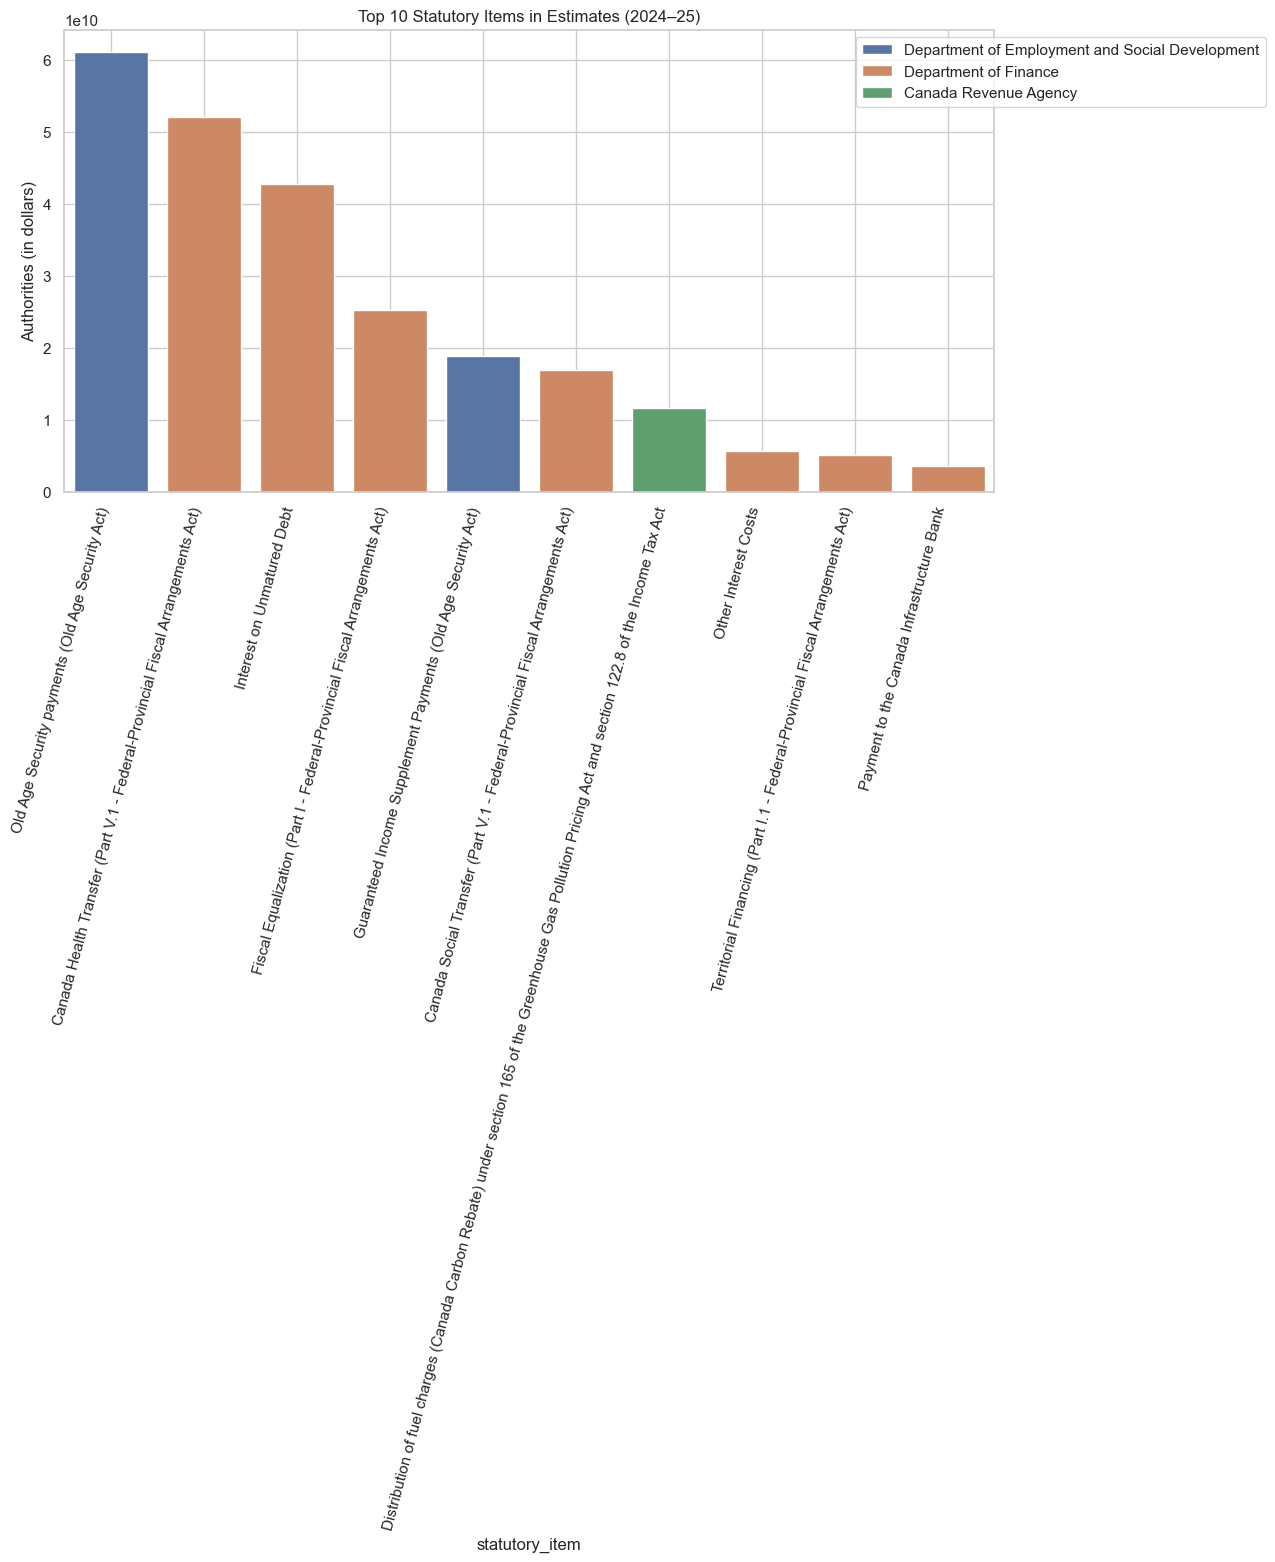

In [73]:
# Define the correct file path
file_statutory = "C:/Users/priya/OneDrive/Desktop/pjt/Statutory Forecasts.csv"

# Load the CSV file
df_statutory = pd.read_csv(file_statutory)

# Filter for FY 2024-25
df_statutory_2024 = df_statutory[df_statutory['fy_ef'] == "FY 2024-25"].copy()

# Group by organization and statutory item, summing the authorities
statutory_summary = df_statutory_2024.groupby(
    ['organization', 'statutory_item']
)['authorities'].sum().reset_index()

# Sort by authorities in descending order
statutory_summary_sorted = statutory_summary.sort_values(
    by='authorities', ascending=False
).reset_index(drop=True)

# Display the top 10 statutory items for visualization
top10_statutory = statutory_summary_sorted.head(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10_statutory,
    y='authorities',
    x='statutory_item',
    hue='organization',
    dodge=False
)
plt.xticks(rotation=75, ha='right')
plt.ylabel("Authorities (in dollars)")
plt.title("Top 10 Statutory Items in Estimates (2024–25)")
plt.tight_layout()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.show()

In [ ]:
## Analysis: Top 10 Statutory Items in Estimates (2024–25)

This bar chart highlights the top 10 statutory funding allocations in the Canadian government's 2024–25 fiscal estimates. Each bar represents the total authorized amount (in dollars) for a specific statutory item, color-coded by the responsible organization.

---

### Key Observations:

- **Old Age Security (OAS)** receives the highest allocation, exceeding $60 billion. This reflects Canada’s commitment to income support for seniors under the Old Age Security Act, managed by the Department of Employment and Social Development.

- **Canada Health Transfer** ranks second, with over $50 billion authorized under the Federal-Provincial Fiscal Arrangements Act, administered by the Department of Finance. This supports provincial healthcare systems.

- **Interest on Unmatured Debt** — over $40 billion — reflects significant public debt servicing costs, a recurring statutory obligation.

- **Fiscal Equalization** and **Canada Social Transfer** also receive substantial funding, demonstrating the federal government’s role in reducing interprovincial disparities and supporting social services.

- **Guaranteed Income Supplement Payments**, like OAS, target income security for older Canadians, reinforcing the social safety net.

- **Distribution of Fuel Charges (Canada Carbon Rebate)** appears in the top 10, administered by the Canada Revenue Agency, showing the federal commitment to climate-related financial programs.

---

### Insights:

- Social security (OAS, GIS) and health-related transfers dominate statutory spending.
- Debt servicing and equalization remain core non-discretionary priorities.
- Only three organizations (Employment and Social Development, Finance, CRA) manage these top 10 items, highlighting centralized statutory responsibility.

---

### Conclusion:

Statutory expenditures form the non-negotiable foundation of federal budgeting, reflecting long-term commitments to Canadians' welfare, provincial equity, and fiscal responsibility. These items are pre-authorized by law, ensuring stability and predictability in public finance.


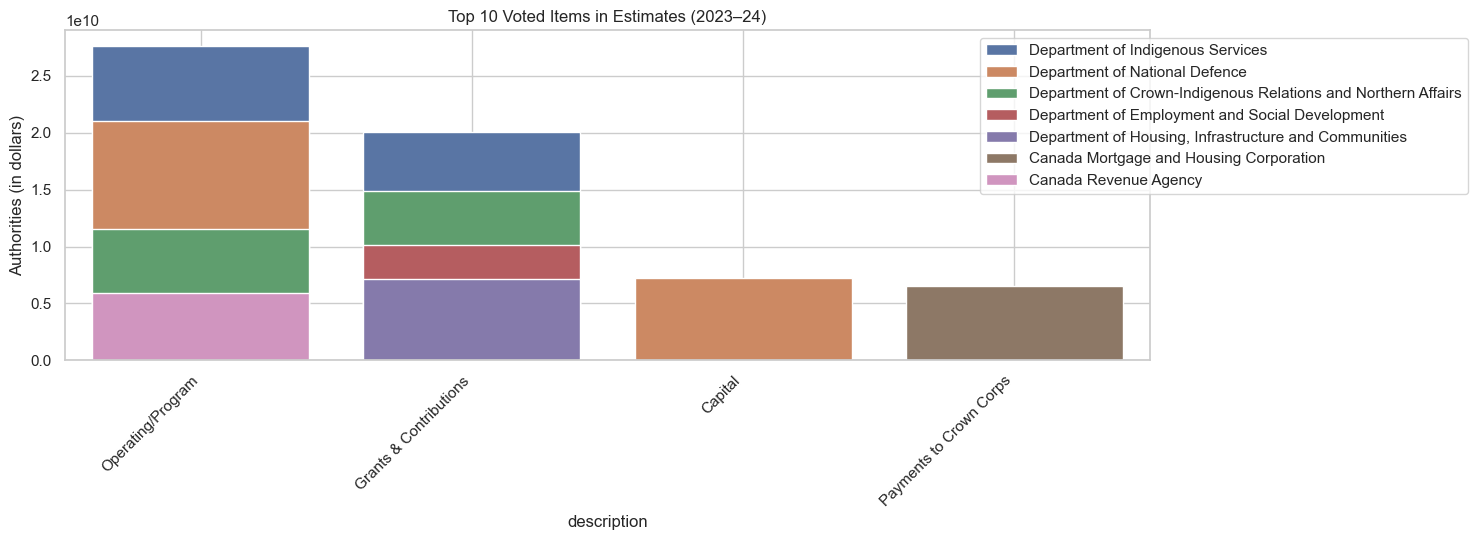

In [94]:


# Load the file
file_path = "C:/Users/priya/OneDrive/Desktop/pjt/Authorities and Expenditures by Vote.csv"
df_voted = pd.read_csv(file_path)

# Step 1: Filter for FY 2023–24
df_voted_2023 = df_voted[df_voted['fy_ef'] == "FY 2023-24"].copy()

# Step 2: Keep only voted items (exclude statutory 'S')
df_voted_2023 = df_voted_2023[df_voted_2023['voted_or_statutory'].str.upper() != 'S']

# Step 3: Group by organization and description, summing authorities and expenditures
voted_summary = df_voted_2023.groupby(
    ['org_name', 'description']
)[['authorities', 'expenditures']].sum().reset_index()

# Step 4: Sort by highest authorities
voted_summary_sorted = voted_summary.sort_values(by='authorities', ascending=False).reset_index(drop=True)

# Step 5: Select top 10 for visualization
top10_voted = voted_summary_sorted.head(10)

# Step 6: Plot
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

sns.barplot(
    data=top10_voted,
    y='authorities',
    x='description',
    hue='org_name',
    dodge=False
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Authorities (in dollars)")
plt.title("Top 10 Voted Items in Estimates (2023–24)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.subplots_adjust(bottom=0.35, top=0.9)
plt.show()


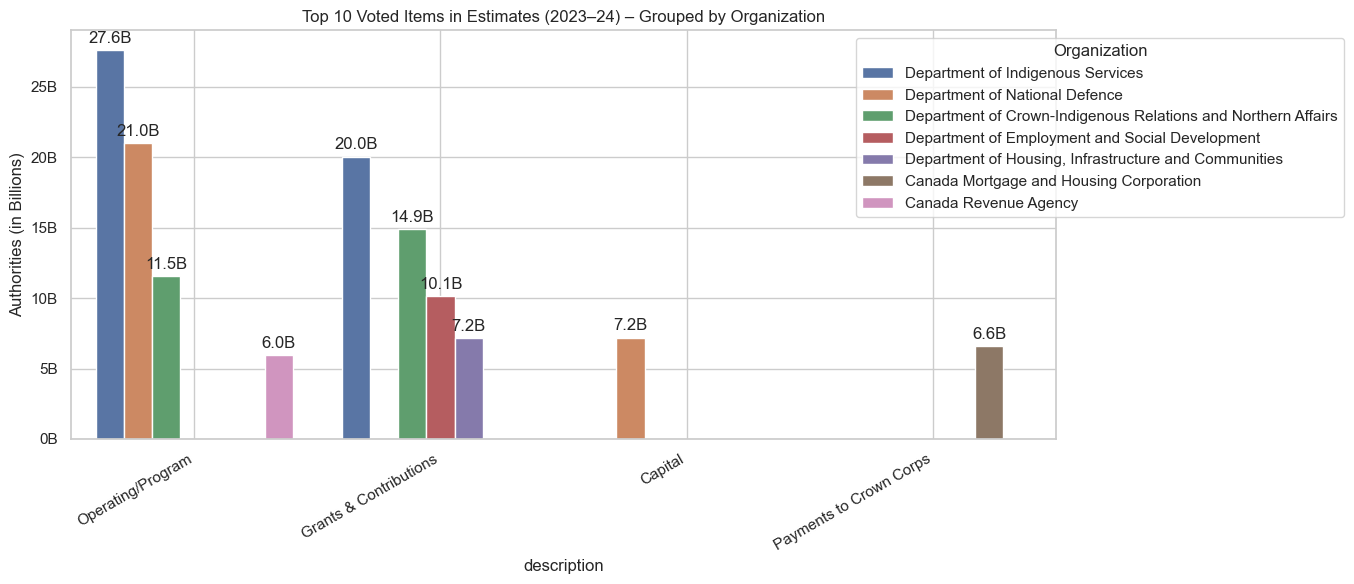

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Load & Filter
file_path = "C:/Users/priya/OneDrive/Desktop/pjt/Authorities and Expenditures by Vote.csv"
df_voted = pd.read_csv(file_path)
df_voted_2023 = df_voted[df_voted['fy_ef'] == "FY 2023-24"].copy()
df_voted_2023 = df_voted_2023[df_voted_2023['voted_or_statutory'].str.upper() != 'S']

# Group & Sort
voted_summary = df_voted_2023.groupby(
    ['org_name', 'description']
)[['authorities', 'expenditures']].sum().reset_index()
voted_summary_sorted = voted_summary.sort_values(by='authorities', ascending=False).reset_index(drop=True)
top10_voted = voted_summary_sorted.head(10)

# Plot
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    data=top10_voted,
    y='authorities',
    x='description',
    hue='org_name',
    dodge=True
)

# Y-axis in billions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 1e-9:.0f}B'))

# X-labels cleanup
plt.xticks(rotation=30, ha='right')
plt.ylabel("Authorities (in Billions)")
plt.title("Top 10 Voted Items in Estimates (2023–24) – Grouped by Organization")

# Add labels on top of bars
for container in ax.containers:
    ax.bar_label(container, labels=[f'{h.get_height() * 1e-9:.1f}B' for h in container], padding=3)

# Final touches
plt.legend(title='Organization', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.grid(True)
plt.show()


### Analysis: Top 10 Voted Items in Estimates (2023–24)

This grouped bar chart presents the top voted expenditure items for the fiscal year 2023–24, categorized by **description** and broken down by **organization**. The values are represented in **billions of dollars (B)**.

---

#### Key Observations:

1. **Dominance of Operating/Program Spending**  
   - The **Department of Indigenous Services** leads with **$27.6B**, the highest single authority value among all categories.  
   - **Department of National Defence** and **Crown-Indigenous Relations and Northern Affairs** follow with **$21.0B** and **$11.5B**, respectively.  
   - This highlights that operational support and service delivery remain core focuses of government spending.

2. **Grants & Contributions as a Major Category**  
   - A significant portion of voted authorities is allocated to **Grants & Contributions** by:
     - Department of Indigenous Services (**$20.0B**)
     - Crown-Indigenous Relations (**$14.9B**)
     - Employment and Social Development (**$10.1B**)  
   - These grants are critical in supporting community programs, social services, and development initiatives.

3. **Capital Expenditures**  
   - **Department of National Defence** leads capital investment with **$7.2B**, possibly reflecting investments in infrastructure or defense equipment.

4. **Payments to Crown Corporations**  
   - **Canada Mortgage and Housing Corporation** is solely responsible for this category with **$6.6B**, suggesting significant investments in housing-related programs.

5. **Diverse Organizational Involvement**  
   - A variety of departments appear across categories, indicating broad engagement in the budget allocation:
     - From **Defense and Employment** to **Housing and Revenue Agencies**, the distribution reflects a multi-sectoral financial strategy.

---

#### Summary:
- There is a clear priority placed on Indigenous services and programs, both operational and through grants.
- Capital investments are more concentrated, particularly in national defense.
- The use of grouped bars effectively reveals how different departments contribute to similar expenditure categories.
